## Загружаем датасет в colab из Kaggle

Подробно расписано, как это делать: https://medium.com/@saedhussain/google-colaboratory-and-kaggle-datasets-b57a83eb6ef8

и здесь: https://www.kaggle.com/general/74235

In [1]:
!ls

sample_data


In [2]:
# Colab library to upload files to notebook
from google.colab import files
import os

In [3]:
# Install Kaggle library
!pip install -q kaggle

In [4]:
# Upload kaggle API key file (надо загрузить kaggle.json, который можно получить из своего профиля kaggle)
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dmitryfedorov1992","key":"7035c735f9ff36dac40780f2fdb80851"}'}

In [5]:
!ls

kaggle.json  sample_data


In [6]:
# API key file надо обязательно закинуть в корневой каталог
! mkdir ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge           COVID-19 Open Research Dataset Challenge (CORD-19)    3GB  2020-06-29 17:04:40          84514  
roche-data-science-coalition/uncover                        UNCOVER COVID-19 Challenge                          179MB  2020-05-21 18:57:53          14566  
josehenriqueroveda/fertilizers-by-product-fao               Fertilizers by Product FAO                            1MB  2020-06-16 13:01:07            364  
madeleineferguson/farmers-markets-in-the-united-states      Farmers Markets in the United States                816KB  2020-06-10 16:41:46            633  
promptcloud/jobs-on-naukricom                               Jobs

In [10]:
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset -p 'stan_dog_dataset'

 98% 739M/750M [00:07<00:00, 121MB/s]
100% 750M/750M [00:07<00:00, 110MB/s]


In [11]:
!ls

kaggle.json  sample_data  stan_dog_dataset


In [12]:
print(os.listdir("/content"))

['.config', 'stan_dog_dataset', 'kaggle.json', 'sample_data']


In [13]:
print(os.listdir("/content/stan_dog_dataset"))

['stanford-dogs-dataset.zip']


In [14]:
!ls 

kaggle.json  sample_data  stan_dog_dataset


In [15]:
os.chdir('stan_dog_dataset')

In [16]:
!ls 

stanford-dogs-dataset.zip


In [17]:
! mkdir dataset

In [18]:
! unzip stanford-dogs-dataset.zip -d dataset

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: dataset/images/Images/n02108089-boxer/n02108089_117.jpg  
  inflating: dataset/images/Images/n02108089-boxer/n02108089_11807.jpg  
  inflating: dataset/images/Images/n02108089-boxer/n02108089_11875.jpg  
  inflating: dataset/images/Images/n02108089-boxer/n02108089_122.jpg  
  inflating: dataset/images/Images/n02108089-boxer/n02108089_12232.jpg  
  inflating: dataset/images/Images/n02108089-boxer/n02108089_125.jpg  
  inflating: dataset/images/Images/n02108089-boxer/n02108089_12738.jpg  
  inflating: dataset/images/Images/n02108089-boxer/n02108089_12739.jpg  
  inflating: dataset/images/Images/n02108089-boxer/n02108089_12827.jpg  
  inflating: dataset/images/Images/n02108089-boxer/n02108089_13340.jpg  
  inflating: dataset/images/Images/n02108089-boxer/n02108089_13526.jpg  
  inflating: dataset/images/Images/n02108089-boxer/n02108089_1353.jpg  
  inflating: dataset/images/Images/n02108089-boxer/n02108089_13

In [19]:
os.listdir("/content/stan_dog_dataset/dataset")

['images', 'annotations']

## Создаем рабочий датасет

Пример взят отсюда https://www.kaggle.com/jingw222/stanford-dogbreeds-a-transfer-learning-tutorial#Confusion-matrix-analysis

In [20]:
import pathlib
import multiprocessing as mp
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf

In [21]:
!ls

dataset  stanford-dogs-dataset.zip


In [22]:
ANNOTATION_DIR = pathlib.Path('./dataset/annotations/Annotation/')
IMAGES_DIR = pathlib.Path('./dataset/images/Images')

In [23]:
BREED_DIR = [path for path in IMAGES_DIR.iterdir()]
BREED_DIR_NAME = [path.name for path in BREED_DIR]

In [24]:
BREED_CODE_TO_NAME = {breed.split('-')[0]: breed[10:] for breed in BREED_DIR_NAME}
BREED_NAME_TO_CODE = {v: k for k, v in BREED_CODE_TO_NAME.items()}

BREED_LABEL_TO_CODE = {i: code for i, code in enumerate(BREED_CODE_TO_NAME)}
BREED_CODE_TO_LABEL = {v: k for k, v in BREED_LABEL_TO_CODE.items()}

BREED_LABEL_TO_NAME = {i: BREED_CODE_TO_NAME[code] for i, code in BREED_LABEL_TO_CODE.items()}
BREED_NAME_TO_LABEL = {v: k for k, v in BREED_LABEL_TO_NAME.items()}

In [25]:
def path_to_label(path):
    code = path.stem.split('_')[0]
    return BREED_CODE_TO_LABEL[code]


def get_all_file_path(directory, file_pattern=''):
    paths = list(f for f in directory.rglob('**/*{}'.format(file_pattern)) if f.is_file())
    return sorted(paths, key=str) 
    
    
all_image_paths = get_all_file_path(IMAGES_DIR, '.jpg') # PosixPath
all_image_labels = [path_to_label(path) for path in all_image_paths] # [0,1,2,...]

assert len(all_image_paths)==len(all_image_labels), 'Numbers of images and labels not match! {}!={}'.format(len(all_image_paths), len(all_image_labels))

# Write labels to file 
with open('labels.txt', 'w') as f:
    f.write('\n'.join(BREED_NAME_TO_LABEL))

In [26]:
# Crop and save images according to boundings
IMAGES_CROPPED_DIR = pathlib.Path('/tmp/images_cropped/')
IMAGES_CROPPED_DIR.mkdir(parents=True, exist_ok=True) 

# Gets object boundings
def parse_bounding(path):
    # Get annotation path from image path
    path = ANNOTATION_DIR / path.parent.name / path.stem
    
    # Parse boundings
    tree = ET.parse(path)
    bndbox = tree.getroot().findall('object')[0].find('bndbox')
    left = int(bndbox.find('xmin').text)
    right = int(bndbox.find('xmax').text) 
    upper = int(bndbox.find('ymin').text)
    lower = int(bndbox.find('ymax').text) 
    
    return (left, upper, right, lower)


def crop_and_save_image(path, save_dir=IMAGES_CROPPED_DIR):
    box = parse_bounding(path)
    
    image = Image.open(path)
    image_cropped = image.crop(box)
    image_cropped = image_cropped.convert('RGB')
    image_cropped.save(save_dir / path.name)

In [27]:
# Crop images according to bounding boxes
try:
    pool = mp.Pool(processes=mp.cpu_count())
    pool.map(crop_and_save_image, all_image_paths)
except Exception as e:
    print(e)
finally:
    pool.close()

    
all_image_cropped_paths = get_all_file_path(IMAGES_CROPPED_DIR, '.jpg') # PosixPath
all_image_cropped_labels = [path_to_label(path) for path in all_image_cropped_paths] # [0,1,2,...]

assert len(all_image_paths)==len(all_image_cropped_paths), 'Numbers of images and cropped images not match! {}!={}'.format(len(all_image_paths), len(all_image_cropped_paths))

In [28]:
# IMAGE_PATH = all_image_paths
# LABEL = all_image_labels
IMAGE_PATH = all_image_cropped_paths
LABEL = all_image_cropped_labels

In [29]:
IMAGE_PATH[:5]

[PosixPath('/tmp/images_cropped/n02085620_10074.jpg'),
 PosixPath('/tmp/images_cropped/n02085620_10131.jpg'),
 PosixPath('/tmp/images_cropped/n02085620_10621.jpg'),
 PosixPath('/tmp/images_cropped/n02085620_1073.jpg'),
 PosixPath('/tmp/images_cropped/n02085620_10976.jpg')]

In [30]:
LABEL[:5]

[26, 26, 26, 26, 26]

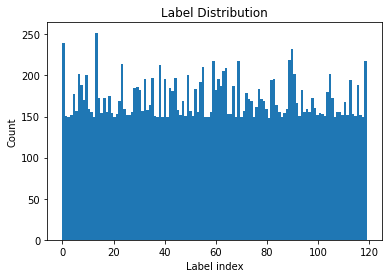

In [31]:
# Label distribution
_ = plt.hist(LABEL, bins=120)
plt.xlabel('Label index')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

Random dog:  West_Highland_white_terrier


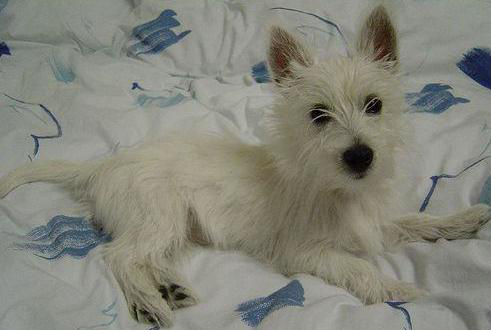

In [32]:
# Ramdomly check a dog image from the dataset
dog = np.random.choice(IMAGE_PATH)
print('Random dog: ', BREED_LABEL_TO_NAME[path_to_label(dog)])
Image.open(dog)

## Загрузка данных

In [33]:
RANDOM_SEED = 12345
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [34]:
TEST_SIZE = 0.2
INPUT_IMAGE_SIZE = 224

BATCH_SIZE = 24
EPOCH = 5

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [35]:
x_train, x_test, y_train, y_test = train_test_split(IMAGE_PATH, 
                                                    LABEL,
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_SEED,
                                                    shuffle=True,
                                                    stratify=LABEL)

print('Train data: ', len(x_train))
print('Test data: ', len(x_test))

Train data:  16464
Test data:  4116


In [36]:
def augmentation(image, label=None):
    image = tf.image.random_flip_left_right(image, seed=RANDOM_SEED)
    image = tf.image.random_brightness(image, max_delta=0.1, seed=RANDOM_SEED)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1, seed=RANDOM_SEED)
    if label is None:
        return image
    return image, label


def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE])
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image


def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)


def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

In [37]:
ds_train = tf.data.Dataset.from_tensor_slices(([str(path) for path in x_train], y_train))
ds_test = tf.data.Dataset.from_tensor_slices(([str(path) for path in x_test], y_test))

# Apply shuffle and repeat on training data
ds_train = ds_train.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=len(x_train), seed=RANDOM_SEED))

# Preprocessing
ds_train = ds_train.map(load_and_preprocess_from_path_label, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.map(load_and_preprocess_from_path_label, num_parallel_calls=AUTOTUNE)

# Augmentation
# ds_train = ds_train.map(augmentation, num_parallel_calls=AUTOTUNE)

ds_train = ds_train.batch(BATCH_SIZE)
ds_test = ds_test.batch(BATCH_SIZE)

# `prefetch` lets the dataset fetch batches in the background while the model is training.
ds_train = ds_train.prefetch(buffer_size=1)

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


## Создание модели (MobileNetV2)

In [69]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE, 3), include_top=False)
base_model.trainable = False

### Применение Transfer learning

In [70]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(BREED_NAME_TO_LABEL), 
                          activation='softmax', 
                          kernel_initializer=tf.keras.initializers.glorot_normal(seed=RANDOM_SEED),
                          bias_initializer='zeros',
                          name='predictions')
])

In [71]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"]
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
predictions (Dense)          (None, 120)               153720    
Total params: 2,411,704
Trainable params: 153,720
Non-trainable params: 2,257,984
_________________________________________________________________


In [72]:
# Start training the model
steps_per_epoch = len(x_train)//BATCH_SIZE
history = model.fit(ds_train, epochs=EPOCH, validation_data=ds_test, steps_per_epoch=steps_per_epoch)

Epoch 1/5
686/686 [==============================] - 54s 78ms/step - loss: 0.9389 - accuracy: 0.7579 - val_loss: 0.5342 - val_accuracy: 0.8341
Epoch 2/5
686/686 [==============================] - 53s 77ms/step - loss: 0.3486 - accuracy: 0.8929 - val_loss: 0.4877 - val_accuracy: 0.8496
Epoch 3/5
686/686 [==============================] - 53s 77ms/step - loss: 0.2336 - accuracy: 0.9306 - val_loss: 0.5036 - val_accuracy: 0.8462
Epoch 4/5
686/686 [==============================] - 53s 77ms/step - loss: 0.1609 - accuracy: 0.9570 - val_loss: 0.4970 - val_accuracy: 0.8518
Epoch 5/5
686/686 [==============================] - 53s 77ms/step - loss: 0.1162 - accuracy: 0.9719 - val_loss: 0.4979 - val_accuracy: 0.8503


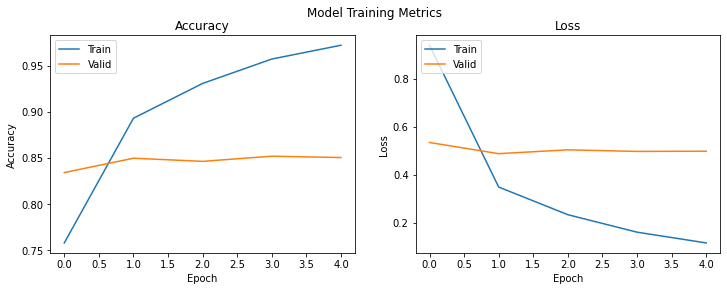

In [73]:
# Plot training & validation metrics
def plot_model_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Model Training Metrics')

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.title.set_text('Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Valid'], loc='upper left')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.title.set_text('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Valid'], loc='upper left')

    fig.show()
    
    
plot_model_history(history)

## Создание модели (EfficientNetB4)

In [74]:
! pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-88hd9mjh
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-88hd9mjh
  Created wheel for efficientnet: filename=efficientnet-1.1.0-cp36-none-any.whl size=18327 sha256=b41367953a56cca71d01431e5b6dfac39b46cc6ab468cca4fec56c17add5d56b
  Stored in directory: /tmp/pip-ephem-wheel-cache-7puk_q5o/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet


In [75]:
import efficientnet.tfkeras as efn

In [78]:
base_model = efn.EfficientNetB4(input_shape=(INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE, 3), include_top=False)

In [79]:
base_model.trainable = False

### Применение Transfer learning

In [80]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(BREED_NAME_TO_LABEL), 
                          activation='softmax', 
                          kernel_initializer=tf.keras.initializers.glorot_normal(seed=RANDOM_SEED),
                          bias_initializer='zeros',
                          name='predictions')
])

In [81]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"]
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 7, 7, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1792)              0         
_________________________________________________________________
predictions (Dense)          (None, 120)               215160    
Total params: 17,888,976
Trainable params: 215,160
Non-trainable params: 17,673,816
_________________________________________________________________


In [82]:
# Start training the model
steps_per_epoch = len(x_train)//BATCH_SIZE
history = model.fit(ds_train, epochs=EPOCH, validation_data=ds_test, steps_per_epoch=steps_per_epoch)

Epoch 1/5
686/686 [==============================] - 201s 293ms/step - loss: 0.9918 - accuracy: 0.8010 - val_loss: 0.3629 - val_accuracy: 0.8904
Epoch 2/5
686/686 [==============================] - 198s 288ms/step - loss: 0.3799 - accuracy: 0.8836 - val_loss: 0.3310 - val_accuracy: 0.8960
Epoch 3/5
686/686 [==============================] - 197s 287ms/step - loss: 0.3175 - accuracy: 0.8993 - val_loss: 0.3347 - val_accuracy: 0.8941
Epoch 4/5
686/686 [==============================] - 196s 286ms/step - loss: 0.2715 - accuracy: 0.9114 - val_loss: 0.3392 - val_accuracy: 0.8938
Epoch 5/5
686/686 [==============================] - 197s 288ms/step - loss: 0.2474 - accuracy: 0.9208 - val_loss: 0.3456 - val_accuracy: 0.8941


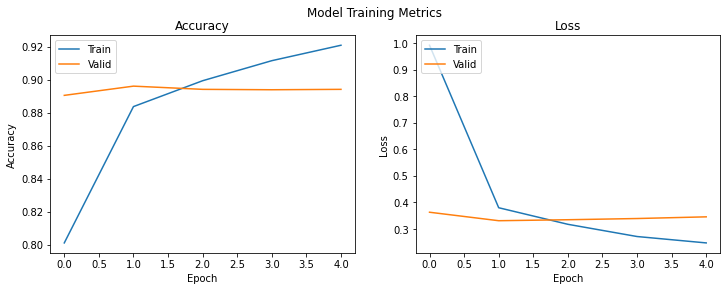

In [83]:
# Plot training & validation metrics
def plot_model_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Model Training Metrics')

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.title.set_text('Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Valid'], loc='upper left')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.title.set_text('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Valid'], loc='upper left')

    fig.show()
    
    
plot_model_history(history)